In [1]:
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import sys

# Connect to MySQL Server

In [2]:
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  passwd="enron",
  database="emails",
  auth_plugin='mysql_native_password'
)

In [3]:
mycursor = mydb.cursor()

# Extract Data to Pandas

In [4]:
mycursor.execute("SELECT * FROM message")

myresult = mycursor.fetchall()

email_df = pd.DataFrame(myresult)

email_df.columns = ['mid','sender','date','message_id','subject','body','folder']

email_df.head(3)

mid                     sender                 date  \
0   52    press.release@enron.com  2000-01-21 04:51:00   
1   53  office.chairman@enron.com  2000-01-24 01:37:00   
2   54  office.chairman@enron.com  2000-01-24 02:06:00   

                                      message_id  \
0  <12435833.1075863606729.JavaMail.evans@thyme>   
1  <29664079.1075863606676.JavaMail.evans@thyme>   
2  <15300605.1075863606629.JavaMail.evans@thyme>   

                                             subject  \
0  ENRON HOSTS ANNUAL ANALYST CONFERENCE PROVIDES...   
1                    Over $50 -- You made it happen!   
2                    Over $50 -- You made it happen!   

                                                body  \
0  HOUSTON - Enron Corp. hosted its annual equity...   
1  On Wall Street, people are talking about Enron...   
2  On Wall Street, people are talking about Enron...   

                                             folder  
0  Robert_Badeer_Aug2000Notes FoldersPress releases  
1  Robert_Badeer_Aug2000Notes FoldersPress releases  
2  Robert_Badeer_Aug2000Notes FoldersPress releases

In [5]:
mycursor.execute("SELECT * FROM employeelist")

myresult = mycursor.fetchall()

employee_df = pd.DataFrame(myresult)

employee_df.columns = ['eid','first_name','last_name','email_id']

employee_df.head(3)

eid first_name last_name                 email_id
0   18       Lynn     Blair     lynn.blair@enron.com
1   17       Mike   Grigsby   mike.grigsby@enron.com
2   16   Michelle      Cash  michelle.cash@enron.com

In [6]:
mycursor.execute("SELECT * FROM recipientinfo")

myresult = mycursor.fetchall()

recipient_df = pd.DataFrame(myresult)

recipient_df.columns = ['rid','mid','r_type','r_value','date_r']

recipient_df.head(3)

rid  mid r_type                        r_value date_r
0   67   52     TO        all.worldwide@enron.com   None
1   68   53     TO         all.downtown@enron.com   None
2   69   54     TO  all.enron-worldwide@enron.com   None

In [7]:
mycursor.execute("SELECT * FROM referenceinfo")

myresult = mycursor.fetchall()

reference_df = pd.DataFrame(myresult)

reference_df.columns = ['rfid','mid','reference']

reference_df.head(3)

rfid  mid                                          reference
0     2   79  > From: Le Vine, Debi> Sent: Thursday, August ...
1     3   99  > From: Golden, Mark> Sent: Thursday, August 2...
2     8  533  From: Sole, JeanneSent: Friday, August 18, 200...

# Data Frame Characteristics

In [8]:
len(set(recipient_df['r_value']))

68224

In [9]:
len(reference_df)

54778

In [10]:
len(set(email_df['folder']))

3893

# Create Dataframe of email records with sender and reciever information

In [11]:
# create mapping of messages to lists of recipients and how many recipients that email has
mid_dict = {}
count =0
total = len(recipient_df)
for mid,r_value in zip(recipient_df['mid'],recipient_df['r_value']) :
    if mid in mid_dict.keys():
        mid_dict[mid].append(r_value)
    else:
        mid_dict[mid] = [r_value]

In [12]:
#unique message IDs, hopefully the same as len(email_df)
len(mid_dict)

252759

(0, 5000)

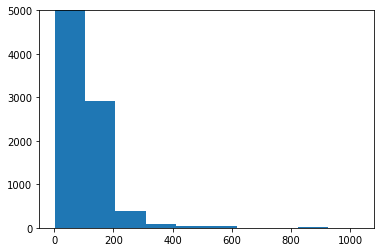

In [13]:
network_df = pd.DataFrame()

network_df['mid'] = list(set(recipient_df['mid']))


lst = []
lst_num = []
for mid in network_df['mid']:
    lst.append(mid_dict[mid])
    lst_num.append(len(mid_dict[mid]))
network_df['rec_list'] = lst
network_df['rec_count'] = lst_num


plt.hist(network_df['rec_count'])
plt.ylim(0,5000)

In [14]:
network_df = network_df.merge(email_df[['mid','sender','date']])

network_df.head()

mid                                           rec_list  rec_count  \
0   52                          [all.worldwide@enron.com]          1   
1   53                           [all.downtown@enron.com]          1   
2   54                    [all.enron-worldwide@enron.com]          1   
3   55                          [all.worldwide@enron.com]          1   
4   56  [all_enron_north.america@enron.com, ec.communi...          2   

                      sender                 date  
0    press.release@enron.com  2000-01-21 04:51:00  
1  office.chairman@enron.com  2000-01-24 01:37:00  
2  office.chairman@enron.com  2000-01-24 02:06:00  
3    press.release@enron.com  2000-02-02 10:21:00  
4  office.chairman@enron.com  2000-02-07 22:16:00

# Create Mapping of users to IDs that includes all known users

In [15]:
main_emails = list(employee_df['email_id'])
len(main_emails)

151

In [16]:
all_users = list(set(network_df['sender']))

all_users =  all_users + list(recipient_df['r_value'])

all_users = list(set(all_users))

len(all_users)

75557

In [17]:
email_to_id = {}
id_to_email ={}
count = 0
for user in all_users:
    email_to_id[user] = count
    id_to_email[count] = user
    count+=1

In [18]:
#[sender in main_emails for sender in email_df['sender']]

In [19]:
# How many of the emails in the corpus originate from the main users
sum([(sender in main_emails) for sender in network_df['sender']])

87120

In [20]:
user_matrix = np.zeros((len(all_users),len(all_users)))

In [21]:
for sender,rec_list,rec_count in zip(network_df['sender'],network_df['rec_list'],network_df['rec_count']):
    for rec in rec_list:
        user_matrix[email_to_id[sender]][email_to_id[rec]] += 1/rec_count
        user_matrix[email_to_id[rec]][email_to_id[sender]] += 1/rec_count

In [22]:
len(network_df)

252759

In [23]:
user_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [24]:
len(user_matrix)

75557

In [25]:
user_totals = sum(user_matrix)

In [26]:
# Set Signifigance Threshhold to be in graph

In [91]:
sig_thresh = np.percentile(user_totals,99.85)

In [92]:
sig_thresh

604.2599969621454

In [93]:
count = 0
sig_ids = []
for total in user_totals:
    if total>sig_thresh:
        sig_ids.append(count)
    count+=1

In [94]:
len(sig_ids)

114

In [95]:
# find Jeffrey Skilling in Data at jeff.skilling@enron.com
employee_df[employee_df['first_name'] =='Jeffrey']

eid first_name last_name                 email_id
36    36    Jeffrey  Shankman    a..shankman@enron.com
129  129    Jeffrey  Skilling  jeff.skilling@enron.com

# Jeffery Skilling Check

In [96]:
email_to_id['jeff.skilling@enron.com'] in sig_ids

True

In [97]:
sum([email_to_id[email] in sig_ids for email in employee_df['email_id'] ])

68

In [98]:
sig_users = [id_to_email[eid] for eid in sig_ids]


# Create Sig Users Network


In [99]:
len(sig_users)

114

In [100]:
sig_email_to_id = {}
sig_id_to_email ={}
count = 0
for user in sig_users:
    sig_email_to_id[user] = count
    sig_id_to_email[count] = user
    if user == 'jeff.skilling@enron.com':
        print('Jeffs ID is ',count)
    count+=1

Jeffs ID is  89


In [101]:
sig_user_matrix = np.zeros((len(sig_users),len(sig_users)))

In [102]:
for sender,rec_list,rec_count in zip(network_df['sender'],network_df['rec_list'],network_df['rec_count']):
    for rec in rec_list:
        if sender in sig_users and rec in sig_users:
            sig_user_matrix[sig_email_to_id[sender]][sig_email_to_id[rec]] += 1/rec_count
            sig_user_matrix[sig_email_to_id[rec]][sig_email_to_id[sender]] += 1/rec_count

In [103]:
sum(sum(sig_user_matrix))

59855.1761019996

In [104]:
sig_user_matrix

array([[1.47619048e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 6.08760263e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.85185185e-02, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 6.77348071e+02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 2.24118352e+02, 0.00000000e+00],
       [6.08760263e+00, 1.85185185e-02, 0.00000000e+00, ...,
        2.24118352e+02, 1.52000000e+01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 2.08000000e+00]])

In [105]:
sig_user_matrix.shape

(114, 114)

In [106]:
#sig_user_matrix[sig_user_matrix>0]=1

In [107]:
sig_user_matrix

array([[1.47619048e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 6.08760263e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.85185185e-02, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 6.77348071e+02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 2.24118352e+02, 0.00000000e+00],
       [6.08760263e+00, 1.85185185e-02, 0.00000000e+00, ...,
        2.24118352e+02, 1.52000000e+01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 2.08000000e+00]])

# Network Vizualization

In [108]:
import plotly.graph_objects as go

import networkx as nx

## create list of edge values to compute percentiles for pruning

In [109]:

edge_values = list(sig_user_matrix)
l =[]
for edges in edge_values:
    l = l + list(edges)
edge_values = l

## ## Save Jeffery Skilling id to find isolated nodes in the network

In [110]:
jeff_sig_id = sig_email_to_id['jeff.skilling@enron.com']

In [111]:
#check Jeff ConnectedNess above threshold
sum(sig_user_matrix[jeff_sig_id]>8)

2

# Create and Prune edges of Network Graph to vizualize

In [112]:
G = nx.Graph()

In [113]:
G.add_nodes_from(range(len(sig_user_matrix)))

In [114]:
edge_thresh = np.percentile(edge_values,95)
for i in range(len(sig_user_matrix)):
    for j in range(len(sig_user_matrix)):
        #if i ==jeff_sig_id:
                #print('jeff_potential')
        if sig_user_matrix[i][j] > edge_thresh:
            #if i ==jeff_sig_id:
                #print('jeff_connection')
            G.add_edge(i,j)

In [115]:
np.percentile(sig_user_matrix,95)

11.147939171147458

In [116]:
### Check Jeff Neighbors

In [117]:
jeff_sig_id

89

## Remove Nodes that do not connect signifigantly to Jeffery


In [118]:
jeff_dist_dict = list((nx.all_pairs_shortest_path_length(G)))[jeff_sig_id][1]
len(jeff_dist_dict)

103

In [119]:
for i in range(len(sig_ids)):
    if i not in jeff_dist_dict:
        G.remove_node(i)

In [120]:
jeff_dist_dict

{89: 0,
 52: 1,
 6: 2,
 32: 2,
 59: 2,
 86: 2,
 93: 2,
 96: 2,
 99: 2,
 14: 3,
 37: 3,
 43: 3,
 3: 3,
 17: 3,
 25: 3,
 46: 3,
 84: 3,
 36: 3,
 47: 3,
 60: 3,
 88: 3,
 104: 3,
 105: 3,
 76: 3,
 15: 3,
 19: 3,
 24: 3,
 30: 3,
 33: 3,
 48: 3,
 70: 3,
 72: 3,
 81: 3,
 82: 3,
 10: 3,
 50: 3,
 73: 3,
 77: 3,
 63: 4,
 41: 4,
 100: 4,
 5: 4,
 29: 4,
 85: 4,
 101: 4,
 109: 4,
 16: 4,
 22: 4,
 0: 4,
 31: 4,
 34: 4,
 40: 4,
 58: 4,
 111: 4,
 112: 4,
 57: 4,
 68: 4,
 78: 4,
 108: 4,
 107: 4,
 1: 4,
 4: 4,
 9: 4,
 28: 4,
 51: 4,
 65: 4,
 69: 4,
 80: 4,
 91: 4,
 97: 4,
 113: 4,
 42: 4,
 87: 4,
 62: 4,
 74: 4,
 79: 4,
 12: 4,
 66: 4,
 18: 4,
 45: 4,
 67: 4,
 83: 4,
 7: 4,
 23: 4,
 54: 4,
 95: 4,
 106: 4,
 8: 4,
 20: 5,
 35: 5,
 26: 5,
 90: 5,
 55: 5,
 92: 5,
 71: 5,
 13: 5,
 102: 5,
 75: 5,
 98: 5,
 103: 5,
 49: 5,
 61: 5,
 2: 6}

In [121]:
#Removing node disconected Nodes
#remove = [node for node,degree in dict(G.degree()).items() if degree < 2]
#G.remove_nodes_from(remove)

In [122]:
G.remove_nodes_from(list(nx.isolates(G)))

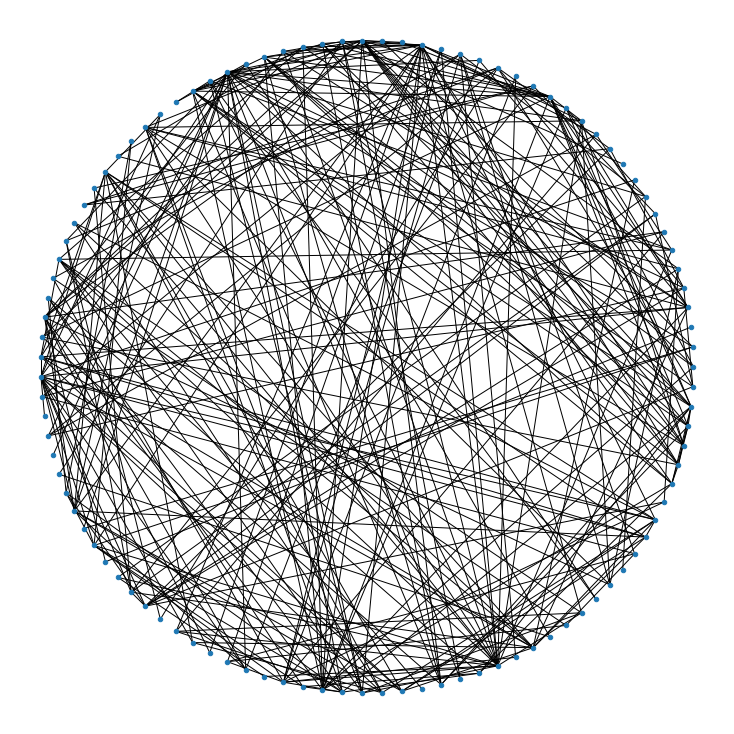

In [123]:
pos = nx.circular_layout(G)

# larger figure size
plt.figure(3,figsize=(10,10)) 
nx.draw(G,pos,node_size=20)
plt.show()

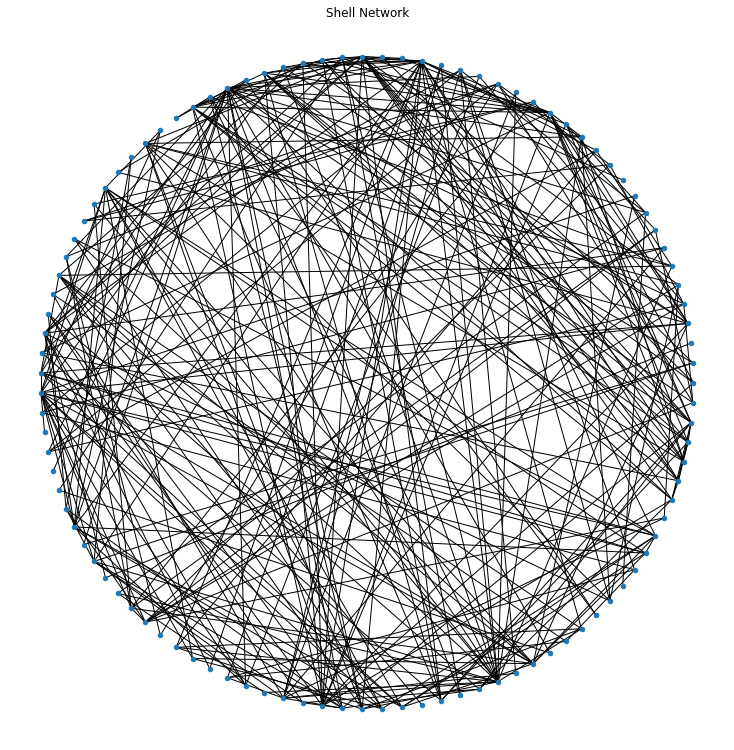

In [124]:
pos = nx.shell_layout(G)

# larger figure size
plt.figure(3,figsize=(10,10)) 
nx.draw(G,pos,node_size=20)
plt.title('Shell Network')
plt.show()


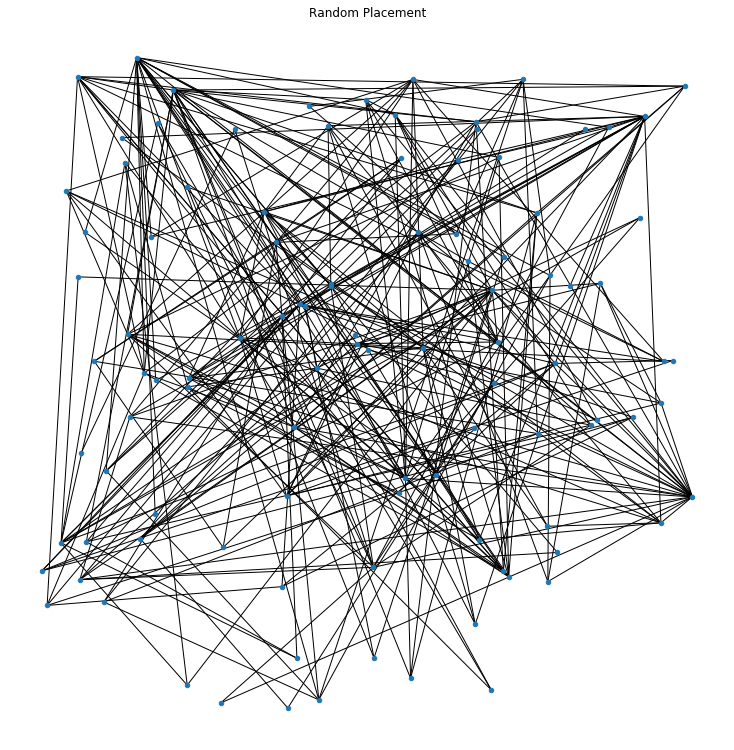

In [125]:
pos = nx.random_layout(G)

# larger figure size
plt.figure(3,figsize=(10,10)) 
nx.draw(G,pos,node_size=20)
plt.title('Random Placement')
plt.show()

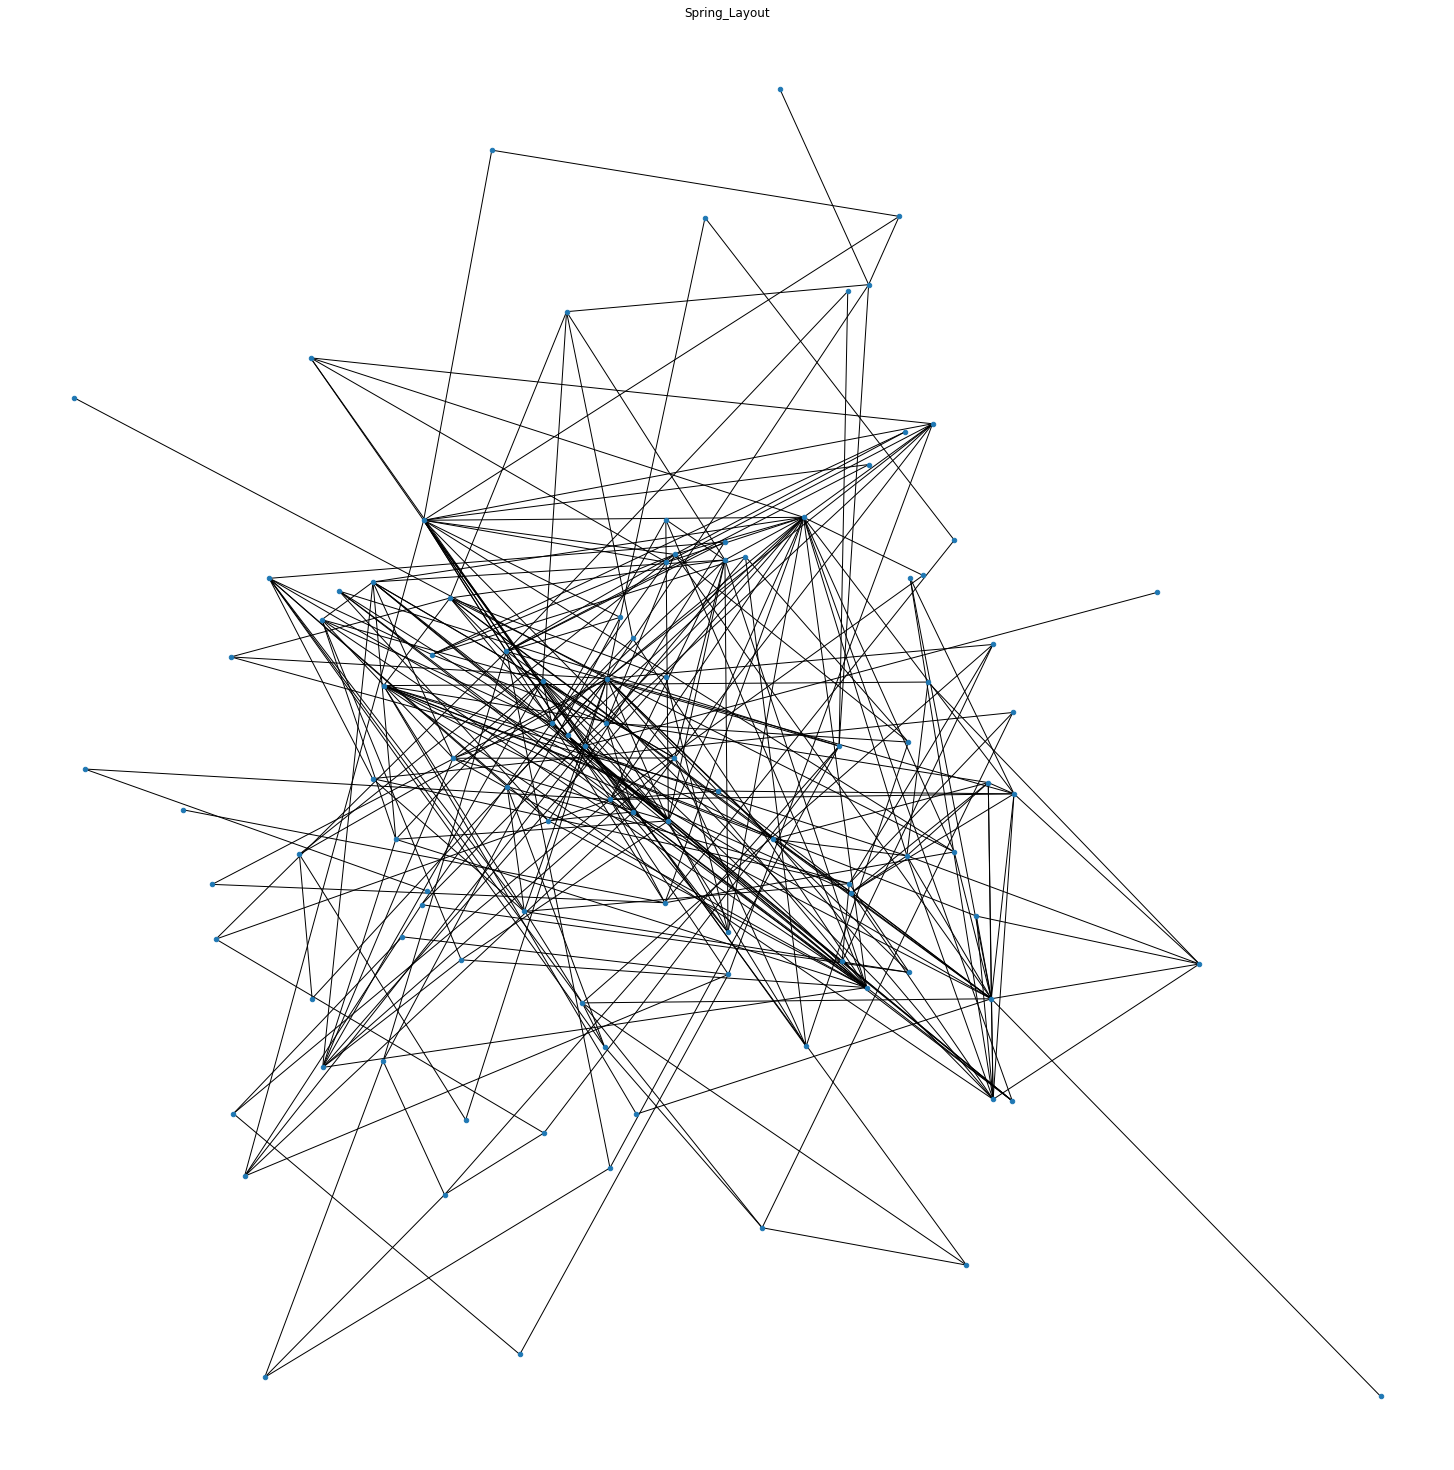

In [126]:
pos = nx.spring_layout(G,iterations=4)

# larger figure size
plt.figure(3,figsize=(20,20)) 
nx.draw(G,pos,node_size=20)
plt.title('Spring_Layout')
plt.show()

# attempt to animate Spring Graph

In [127]:
from IPython.display import HTML
from matplotlib import pyplot as plt
from celluloid import Camera

KeyboardInterrupt: 

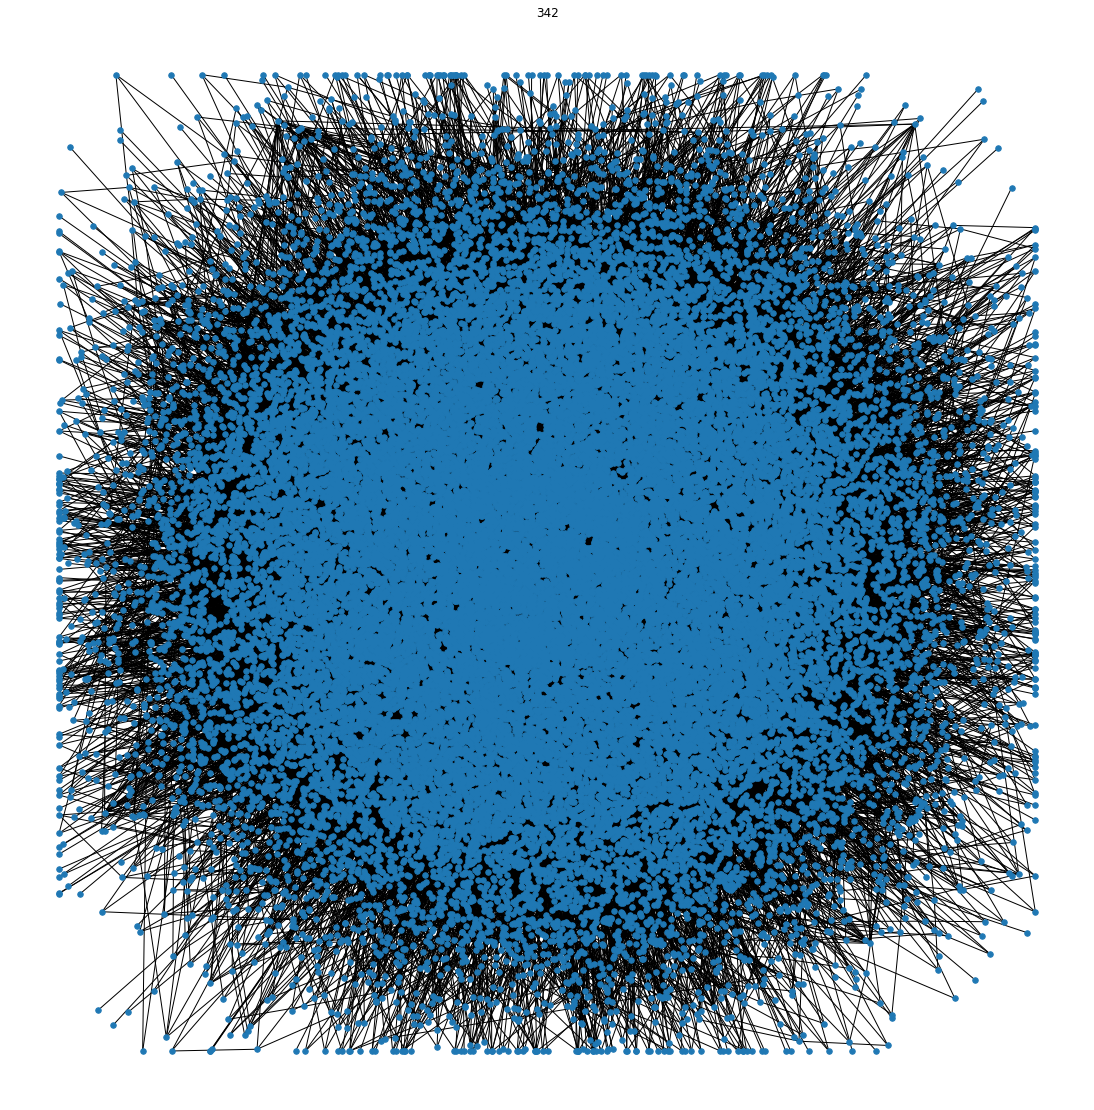

In [128]:
fig = plt.figure(figsize=(15,15))
camera = Camera(fig)
for i in range(5):
    pos = nx.spring_layout(G,iterations=i)
    
    nx.draw(G,pos,node_size=30,k=.2)
    plt.title(i)
    
    camera.snap()
animation = camera.animate(interval=500)
animation.save('celluloid_minimal.gif', writer = 'imagemagick')
HTML(animation.to_jshtml())

In [ ]:
pos = nx.shell_layout(G)

# larger figure size
plt.figure(3,figsize=(10,10)) 
nx.draw(G,pos,node_size=20)
plt.title('Shell Network Based on Jeff Proximity')
plt.show()

# Animate Shells Layout

In [129]:
jeff_dist_dict[0]

4

In [130]:
jefff_groups = []
for i in range(10):
    i_range_list = []
    for key,value in jeff_dist_dict.items():
        if jeff_dist_dict[key] ==i:
            i_range_list.append(key)
    jefff_groups.append(i_range_list)
            

In [131]:
while [] in jefff_groups:
    jefff_groups.remove([])
jefff_groups

[[89],
 [52],
 [6, 32, 59, 86, 93, 96, 99],
 [14,
  37,
  43,
  3,
  17,
  25,
  46,
  84,
  36,
  47,
  60,
  88,
  104,
  105,
  76,
  15,
  19,
  24,
  30,
  33,
  48,
  70,
  72,
  81,
  82,
  10,
  50,
  73,
  77],
 [63,
  41,
  100,
  5,
  29,
  85,
  101,
  109,
  16,
  22,
  0,
  31,
  34,
  40,
  58,
  111,
  112,
  57,
  68,
  78,
  108,
  107,
  1,
  4,
  9,
  28,
  51,
  65,
  69,
  80,
  91,
  97,
  113,
  42,
  87,
  62,
  74,
  79,
  12,
  66,
  18,
  45,
  67,
  83,
  7,
  23,
  54,
  95,
  106,
  8],
 [20, 35, 26, 90, 55, 92, 71, 13, 102, 75, 98, 103, 49, 61],
 [2]]

In [135]:
def draw_shells():
    
    pos = nx.shell_layout(G,nlist=jefff_groups)
    # larger figure size
    plt.figure(3,figsize=(10,10)) 
    nx.draw(G,pos,node_size=60)
    plt.title('Shell Network Based on Jeff Proximity')


//anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.



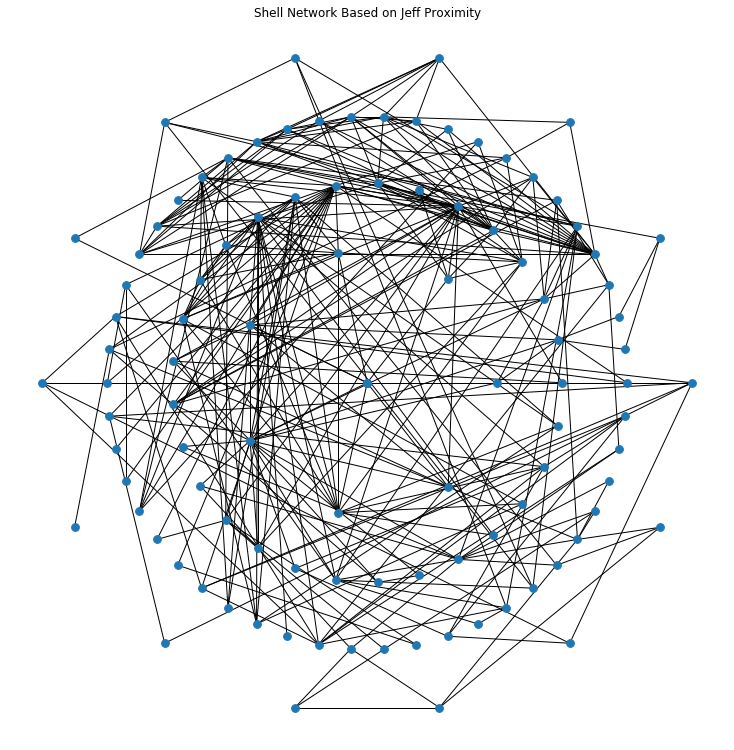

In [136]:
draw_shells()

//anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.



<Figure size 1080x1080 with 0 Axes>

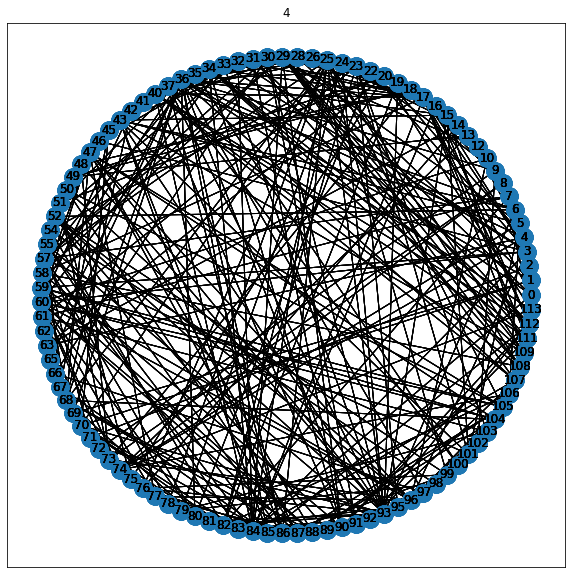

In [138]:
fig = plt.figure(figsize=(15,15))
camera = Camera(fig)
for i in range(5):
    pos = nx.spring_layout(G,iterations=i)
    
    pos = nx.shell_layout(G)
    # larger figure size
    plt.figure(3,figsize=(10,10)) 
    nx.draw_networkx(G,pos,node_size=300)
    plt.title('Shell Network Based on Jeff Proximity')
    plt.title(i)
    
    camera.snap()
animation = camera.animate(interval=500)
animation.save('celluloid_minimal.gif', writer = 'imagemagick')
HTML(animation.to_jshtml())